In [1]:
# 1. Environment & Imports
import sys, os, warnings, random
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Ensure project root is on path
sys.path.append('/home/sultanan/energy')
from energy_pred import (
    GicaHackDataLoader,
    NaiveForecaster,
    SeasonalNaiveForecaster,
    MovingAverageForecaster,
    ExpSmoothingForecaster,
    mae, mape, rmse
)
print('Imports OK')

Imports OK


In [2]:
# 2. Load CSV Exports with GicaHackDataLoader
DATA_DIR = '/home/sultanan/datasets/energy/GicaHack'
loader = GicaHackDataLoader(DATA_DIR, verbose=True)
loader.load()
raw_df = loader.get_raw()
print('Raw shape:', raw_df.shape)
print(raw_df.head())
print('Meters:', loader.list_meters()[:10])
print(loader.stats().head())

Skipping empty file: 03.06.2025 06_00_All measuring points_ExportFile.csv
Skipping empty file: 03.06.2025 18_01_All measuring points_ExportFile.csv
Skipping empty file: 04.06.2025 06_00_All measuring points_ExportFile.csv
Concatenated shape: (2254330, 5)
Raw shape: (2254330, 8)
      meter           timestamp  energy_import  energy_export  transform_coef  \
0  13836498 2025-06-01 12:15:00      6517117.0          469.0             1.0   
1  13836498 2025-06-01 12:30:00      6517160.0          469.0             1.0   
2  13836498 2025-06-01 12:45:00      6517205.0          469.0             1.0   
3  13836498 2025-06-01 13:00:00      6517249.0          469.0             1.0   
4  13836498 2025-06-01 13:15:00      6517296.0          469.0             1.0   

   import_diff  export_diff  period_min  
0          0.0          0.0         0.0  
1         43.0          0.0        15.0  
2         45.0          0.0        15.0  
3         44.0          0.0        15.0  
4         47.0          

In [3]:
raw_df.head()

,meter,timestamp,energy_import,energy_export,transform_coef,import_diff,export_diff,period_min
0,13836498,2025-06-01 12:15:00,6517117.0,469.0,1.0,0.0,0.0,0.0
1,13836498,2025-06-01 12:30:00,6517160.0,469.0,1.0,43.0,0.0,15.0
2,13836498,2025-06-01 12:45:00,6517205.0,469.0,1.0,45.0,0.0,15.0
3,13836498,2025-06-01 13:00:00,6517249.0,469.0,1.0,44.0,0.0,15.0
4,13836498,2025-06-01 13:15:00,6517296.0,469.0,1.0,47.0,0.0,15.0


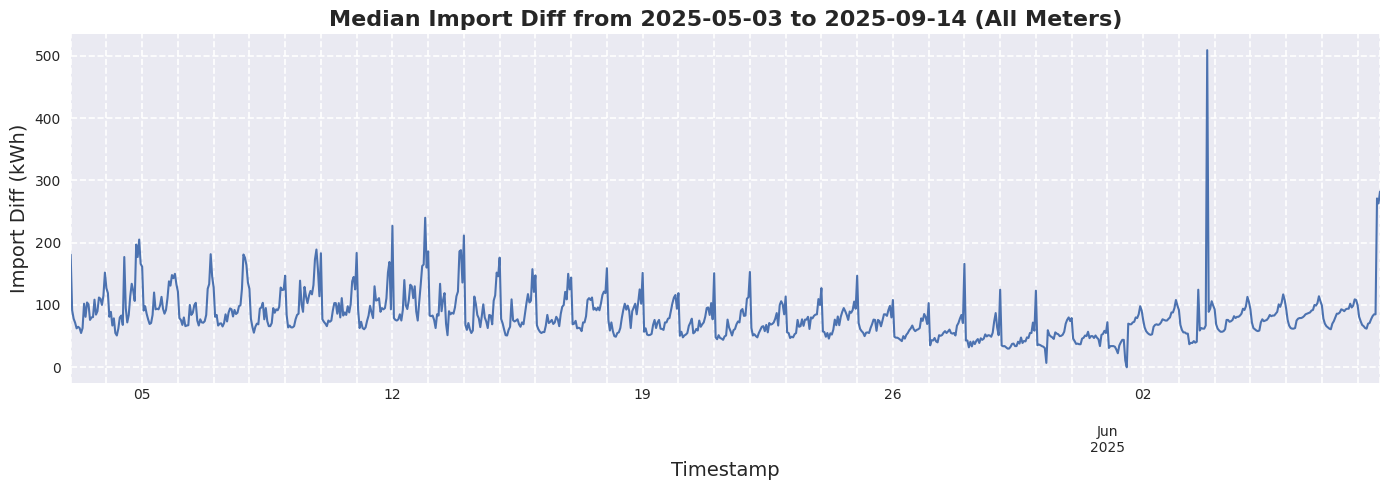

In [46]:
# plot import_diff median based on all meters from time_1 to time_2
time_1 = '2025-05-03'
time_2 = '2025-09-14'
plt.figure(figsize=(14,5))
df_2025 = raw_df[raw_df['timestamp'] >= time_1]
df_2025 = df_2025[df_2025['timestamp'] < time_2]
df_2025 = df_2025.set_index('timestamp')
df_2025 = df_2025.groupby('meter').resample('H').median()
df_2025 = df_2025.reset_index(level='timestamp')
df_2025 = df_2025.set_index('timestamp')
df_2025 = df_2025.groupby('timestamp')['import_diff'].median()
df_2025.plot(lw=1.5)
plt.title(f'Median Import Diff from {time_1} to {time_2} (All Meters)', fontsize=16, weight='bold')
plt.xlabel('Timestamp', fontsize=14)
# plt.yscale('log')
plt.ylabel('Import Diff (kWh)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.tight_layout()
plt.show()

In [5]:
df_2025.head()

timestamp
2025-05-03 00:00:00    181.0
2025-05-03 01:00:00     91.5
2025-05-03 02:00:00     78.0
2025-05-03 03:00:00     71.5
2025-05-03 04:00:00     62.5
Name: import_diff, dtype: float64

Step 1: Normalizing data for each meter to a 15-minute frequency...
Step 2: Aggregating to final hourly median...

--- Processed DataFrame Head ---
                     import_diff_median
timestamp                              
2024-10-01 00:00:00                 0.0
2024-10-01 01:00:00                 0.0
2024-10-01 02:00:00                 0.0
2024-10-01 03:00:00                 0.0
2024-10-01 04:00:00                 0.0


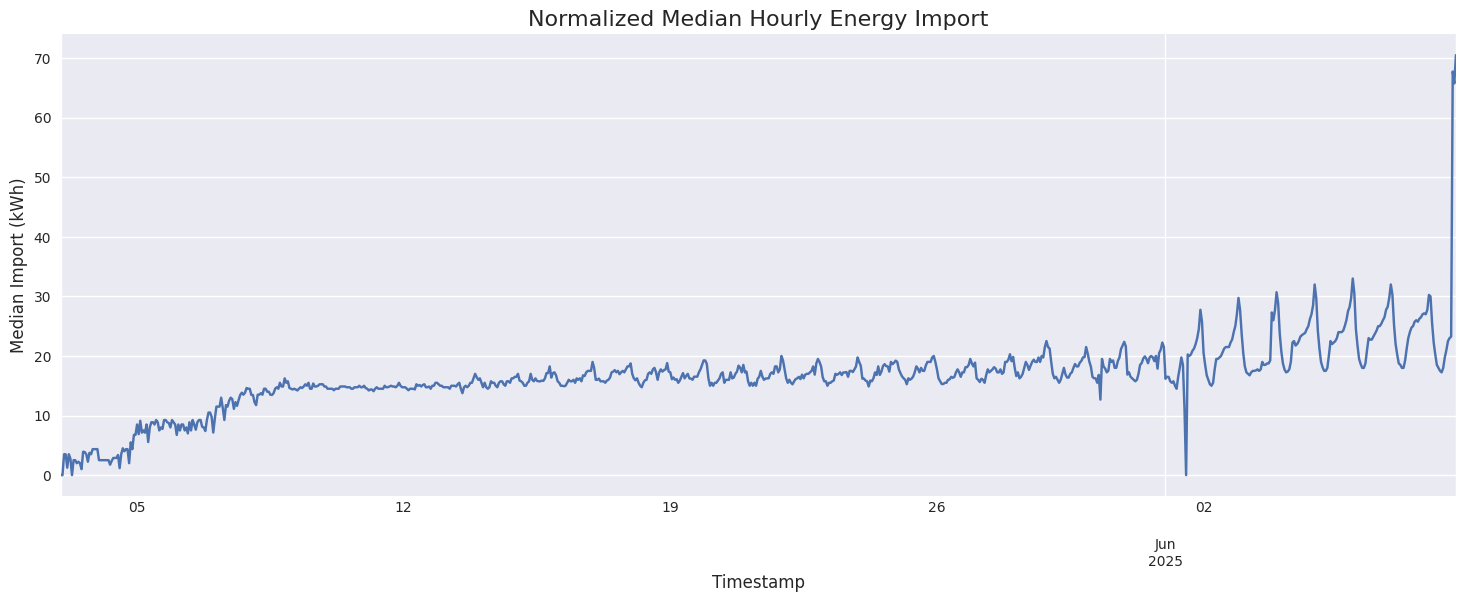

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_and_normalize_consumption(raw_df):
    """
    Normalizes raw smart meter data by distributing accumulated consumption
    over a consistent 15-minute frequency, then aggregates to a final
    hourly median across all meters.

    Args:
        raw_df (pd.DataFrame): DataFrame with columns ['timestamp', 'meter', 'import_diff']
                               where 'timestamp' can have variable time gaps.

    Returns:
        pd.DataFrame: A DataFrame indexed by the hour, with a single column
                      containing the median hourly energy consumption.
    """
    # Ensure timestamp column is in datetime format
    raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'])

    def normalize_meter_data(df_meter):
        """
        Processes data for a single meter. This function is intended to be
        used with pandas' .groupby().apply().
        """
        # Set timestamp as index and sort to ensure correct time delta calculation
        df_meter = df_meter.sort_values('timestamp').set_index('timestamp')

        # --- FIX: Aggregate duplicate timestamps before resampling ---
        # This is the most common cause of the reindexing error. We take the mean
        # of any values that occur at the exact same timestamp for a single meter.
        if df_meter.index.has_duplicates:
            df_meter = df_meter.groupby(df_meter.index).mean()

        # 1. Calculate time difference (in minutes) between consecutive readings
        time_deltas = df_meter.index.to_series().diff().dt.total_seconds() / 60.0

        # 2. Determine how many 15-minute "bins" each reading represents
        # The first reading's interval is unknown, so we assume it covers one 15-min bin.
        # If a delta is 0 (duplicate timestamp), we also treat it as 1 to avoid division by zero.
        num_bins = (time_deltas / 15.0).fillna(1).replace(0, 1)

        # 3. Normalize the consumption by the number of bins
        # This calculates the average consumption rate per 15 minutes for that period.
        df_meter['normalized_diff'] = df_meter['import_diff'] / num_bins

        # 4. Resample to a consistent 15-minute frequency and forward-fill the calculated rate.
        # This effectively distributes the consumption across the time interval.
        df_resampled = df_meter[['normalized_diff']].resample('15min').ffill()
        
        return df_resampled

    print("Step 1: Normalizing data for each meter to a 15-minute frequency...")
    # Apply the normalization function to each meter's data
    df_normalized = raw_df.groupby('meter').apply(normalize_meter_data)

    print("Step 2: Aggregating to final hourly median...")
    # Reset index to work with 'meter' and 'timestamp' as columns again
    df_normalized = df_normalized.reset_index()

    # --- Now apply your original aggregation logic to the cleaned data ---
    
    # Set timestamp as the index for resampling
    df_normalized = df_normalized.set_index('timestamp')
    
    # Resample to hourly medians FOR EACH METER
    # The 'median' here aggregates the four 15-min values within each hour
    df_hourly_per_meter = df_normalized.groupby('meter').resample('H')['normalized_diff'].median()
    
    # Reset the index so we can group by the hourly timestamp
    df_hourly_per_meter = df_hourly_per_meter.reset_index()
    
    # Finally, get the median across all meters for each hour
    df_final = df_hourly_per_meter.groupby('timestamp')['normalized_diff'].median()
    
    # Return as a DataFrame with a clear column name
    return df_final.to_frame(name='import_diff_median')


# --- Example Usage ---
# Create a sample raw_df that mimics the problem description
raw_df_sample = pd.DataFrame(raw_df)

# Process the data using the new function
df_2025_processed = preprocess_and_normalize_consumption(raw_df_sample)

print("\n--- Processed DataFrame Head ---")
print(df_2025_processed.head())


# --- Your plotting code would now follow ---
time_1 = '2025-05-03'
time_2 = '2025-09-01'

# Assuming df_2025_processed contains your full, processed dataset
df_to_plot = df_2025_processed.loc[time_1:time_2]

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(18, 6))
df_to_plot['import_diff_median'].plot()
plt.title('Normalized Median Hourly Energy Import', fontsize=16)
plt.ylabel('Median Import (kWh)', fontsize=12)
plt.xlabel('Timestamp', fontsize=12)
plt.show()



Step 1: Normalizing data for each meter to a 15-minute frequency...
Step 2: Aggregating to final hourly median...

--- Processed DataFrame Head ---
                     import_diff
timestamp                       
2024-10-01 00:00:00          0.0
2024-10-01 01:00:00          0.0
2024-10-01 02:00:00          0.0
2024-10-01 03:00:00          0.0
2024-10-01 04:00:00          0.0


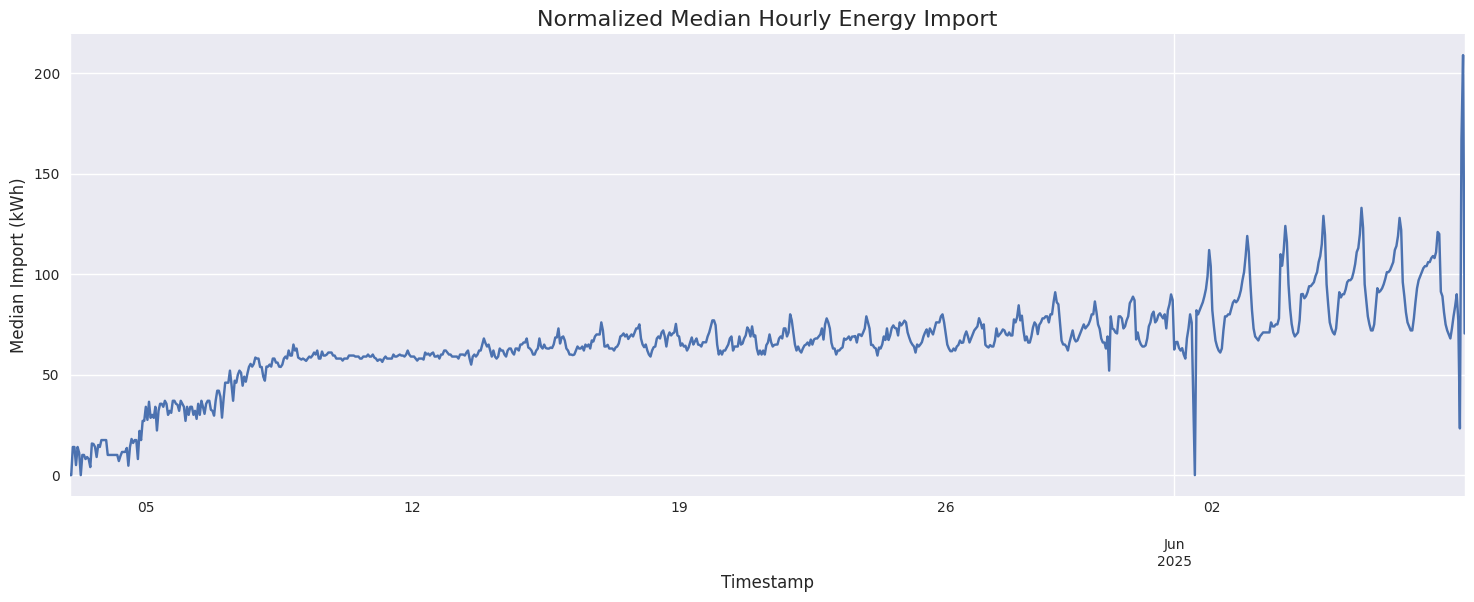

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_and_normalize_consumption(raw_df):
    """
    Normalizes raw smart meter data by distributing accumulated consumption
    over a consistent 15-minute frequency, then aggregates to a final
    hourly median across all meters.

    Args:
        raw_df (pd.DataFrame): DataFrame with columns ['timestamp', 'meter', 'import_diff']
                               where 'timestamp' can have variable time gaps.

    Returns:
        pd.DataFrame: A DataFrame indexed by the hour, with a single column
                      containing the median hourly energy consumption.
    """
    # Ensure timestamp column is in datetime format
    raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'])

    def normalize_meter_data(df_meter):
        """
        Processes data for a single meter. This function is intended to be
        used with pandas' .groupby().apply().
        """
        # Set timestamp as index and sort to ensure correct time delta calculation
        df_meter = df_meter.sort_values('timestamp').set_index('timestamp')

        # FIX: Aggregate duplicate timestamps before resampling
        if df_meter.index.has_duplicates:
            df_meter = df_meter.groupby(df_meter.index).mean()

        # 1. Calculate time difference (in minutes) between consecutive readings
        time_deltas = df_meter.index.to_series().diff().dt.total_seconds() / 60.0

        # 2. Determine how many 15-minute "bins" each reading represents
        num_bins = (time_deltas / 15.0).fillna(1).replace(0, 1)

        # 3. Normalize the consumption by the number of bins
        df_meter['normalized_diff'] = df_meter['import_diff'] / num_bins

        # 4. Resample to a consistent 15-minute frequency and forward-fill
        df_resampled = df_meter[['normalized_diff']].resample('15min').ffill()
        
        return df_resampled

    print("Step 1: Normalizing data for each meter to a 15-minute frequency...")
    df_normalized = raw_df.groupby('meter').apply(normalize_meter_data)

    print("Step 2: Aggregating to final hourly median...")
    df_normalized = df_normalized.reset_index()
    
    # --- MODIFIED LOGIC STARTS HERE ---
    
    df_normalized = df_normalized.set_index('timestamp')
    
    # Step A: Discretize to hourly data for EACH meter by SUMMING the 15-min values.
    # This calculates the total consumption for each hour for each meter.
    df_hourly_per_meter = df_normalized.groupby('meter').resample('H')['normalized_diff'].sum()
    
    # Reset the index so we can group by the hourly timestamp
    df_hourly_per_meter = df_hourly_per_meter.reset_index()
    
    # Step B: Finally, get the median of these hourly consumptions across all meters.
    df_final = df_hourly_per_meter.groupby('timestamp')['normalized_diff'].median()
    
    # --- MODIFIED LOGIC ENDS HERE ---
    
    # Return as a DataFrame with a clear column name
    return df_final.to_frame(name='import_diff')


# --- Example Usage ---
# Create a sample raw_df that mimics the problem description
raw_df_sample = pd.DataFrame(raw_df)

# Process the data using the new function
df_2025_processed = preprocess_and_normalize_consumption(raw_df_sample)

print("\n--- Processed DataFrame Head ---")
print(df_2025_processed.head())


# --- Your plotting code would now follow ---
time_1 = '2025-05-03'
time_2 = '2025-09-01'

# Assuming df_2025_processed contains your full, processed dataset
df_2025_processed = df_2025_processed.loc[time_1:time_2]

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(18, 6))
df_2025_processed['import_diff'].plot()
plt.title('Normalized Median Hourly Energy Import', fontsize=16)
plt.ylabel('Median Import (kWh)', fontsize=12)
plt.xlabel('Timestamp', fontsize=12)
plt.show()



In [29]:
df_2025_processed.head()
# df_2025_processed = df_2025_processed.rename(columns={'import_diff': 'import_diff_median'})

,import_diff
timestamp,
2025-05-03 00:00:00,0.0
2025-05-03 01:00:00,0.0
2025-05-03 02:00:00,14.0
2025-05-03 03:00:00,14.0
2025-05-03 04:00:00,5.0


In [30]:
df_2025.head()

,import_diff,temperature,humidity,pressure
timestamp,,,,
2025-05-03 00:00:00,181.0,12.8,51,1012.9
2025-05-03 01:00:00,91.5,11.5,54,1013.0
2025-05-03 02:00:00,78.0,10.8,55,1012.7
2025-05-03 03:00:00,71.5,11.0,51,1012.1
2025-05-03 04:00:00,62.5,9.7,60,1011.8


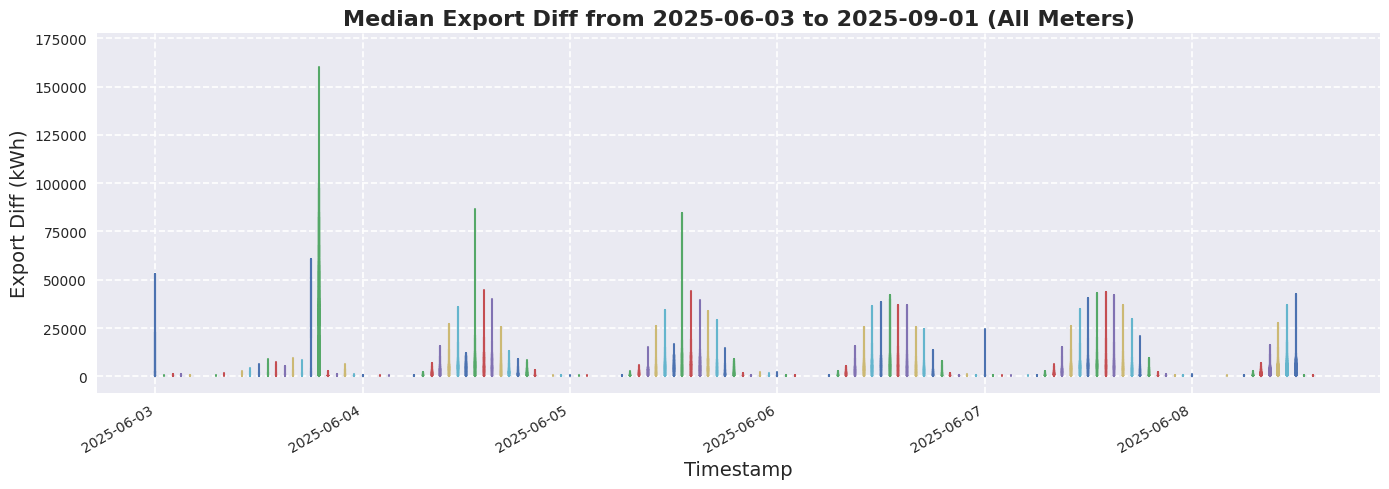

In [31]:
# plot import_diff median among nonzero users based on all meters from time_1 to time_2
time_1 = '2025-06-03'
time_2 = '2025-09-01'
plt.figure(figsize=(14,5))
df_2025_export = raw_df[raw_df['timestamp'] >= time_1]
df_2025_export = df_2025_export[df_2025_export['export_diff'] > 0]
df_2025_export = df_2025_export[df_2025_export['timestamp'] < time_2]
df_2025_export = df_2025_export.set_index('timestamp')
df_2025_export = df_2025_export.groupby('meter').resample('H').median()
df_2025_export = df_2025_export.reset_index(level='timestamp')
df_2025_export = df_2025_export.set_index('timestamp')
df_2025_export = df_2025_export.groupby('timestamp')['export_diff']
df_2025_export.plot(lw=1.5)
plt.title(f'Median Export Diff from {time_1} to {time_2} (All Meters)', fontsize=16, weight='bold')
plt.xlabel('Timestamp', fontsize=14)
# plt.yscale('log')
plt.ylabel('Export Diff (kWh)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.tight_layout()
plt.show()

In [32]:
import requests
def add_weather_features(df, lat=47.01, lon=28.86, tz='Europe/Chisinau'):
    df = pd.DataFrame(df)  # Ensure df is a DataFrame
    """Enriches a DataFrame with historical weather data from Open-Meteo."""
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex.")
    
    start_date = df.index.min().strftime('%Y-%m-%d')
    end_date = df.index.max().strftime('%Y-%m-%d')
    print(f"Fetching weather data for Chișinău from {start_date} to {end_date}...")
    
    api_url = (
        "https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={lat}&longitude={lon}&start_date={start_date}&end_date={end_date}"
        "&hourly=temperature_2m,relative_humidity_2m,surface_pressure"
        f"&timezone={tz}"
    )
    response = requests.get(api_url)
    response.raise_for_status() # Raises an exception for bad status codes
    
    weather_data = response.json()
    df_weather = pd.DataFrame(data=weather_data['hourly'])
    df_weather['time'] = pd.to_datetime(df_weather['time'])
    df_weather = df_weather.set_index('time').rename(columns={
        'temperature_2m': 'temperature', 'relative_humidity_2m': 'humidity', 'surface_pressure': 'pressure'
    })
    
    df_merged = df.merge(df_weather, left_index=True, right_index=True, how='left')
    return df_merged


In [33]:
df_2025 = add_weather_features(pd.DataFrame(df_2025))

Fetching weather data for Chișinău from 2025-05-03 to 2025-06-08...


In [34]:
df_2025_processed = add_weather_features(pd.DataFrame(df_2025_processed))

Fetching weather data for Chișinău from 2025-05-03 to 2025-06-08...


In [35]:
# ds

Размер данных: (880,)

Информация о данных:
<class 'pandas.core.series.Series'>
DatetimeIndex: 880 entries, 2025-05-03 00:00:00 to 2025-06-08 15:00:00
Series name: import_diff
Non-Null Count  Dtype  
--------------  -----  
880 non-null    float64
dtypes: float64(1)
memory usage: 13.8 KB
None

Описательная статистика:
count    880.000000
mean      81.791477
std       36.370670
min        0.000000
25%       59.500000
50%       76.000000
75%       94.125000
max      509.000000
Name: import_diff, dtype: float64
Размер данных после feature engineering: (712, 61)
Категориальные признаки: ['hour', 'day_of_week', 'is_weekend', 'month', 'season']
Train size: 358, Test size: 107


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.8421067	test: 9.0097712	best: 9.0097712 (0)	total: 9.96ms	remaining: 9.96s
200:	learn: 0.2455271	test: 5.5697101	best: 5.5667840 (187)	total: 919ms	remaining: 3.65s
400:	learn: 0.0693356	test: 5.5504886	best: 5.5477627 (356)	total: 1.77s	remaining: 2.64s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.547762733
bestIteration = 356

Shrink model to first 357 iterations.

=== РЕЗУЛЬТАТЫ МОДЕЛИ ===
MAE: 5.55
MAPE: 7.18%
Std of residuals: 5.56
95% Confidence Interval: ±10.90


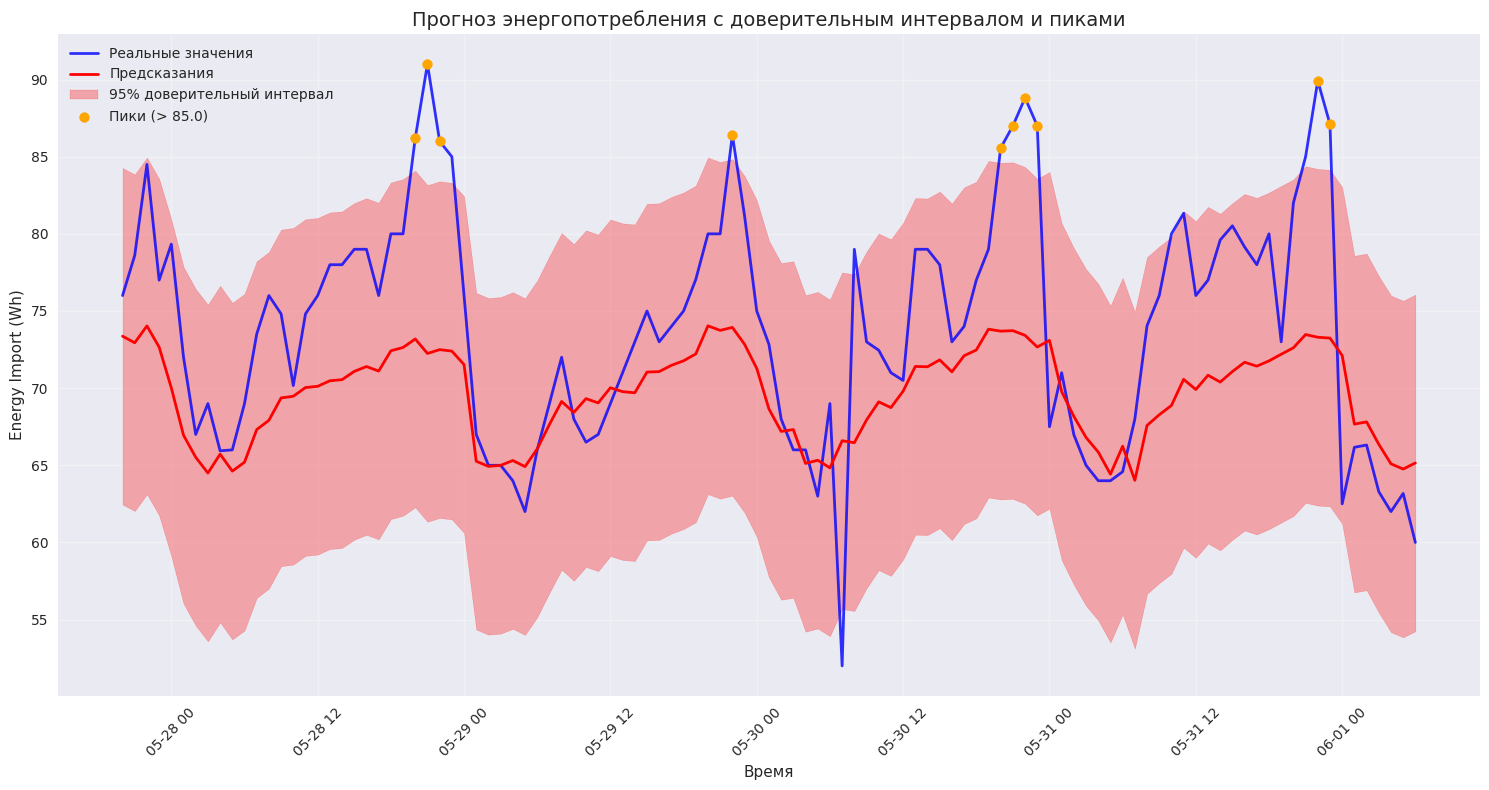

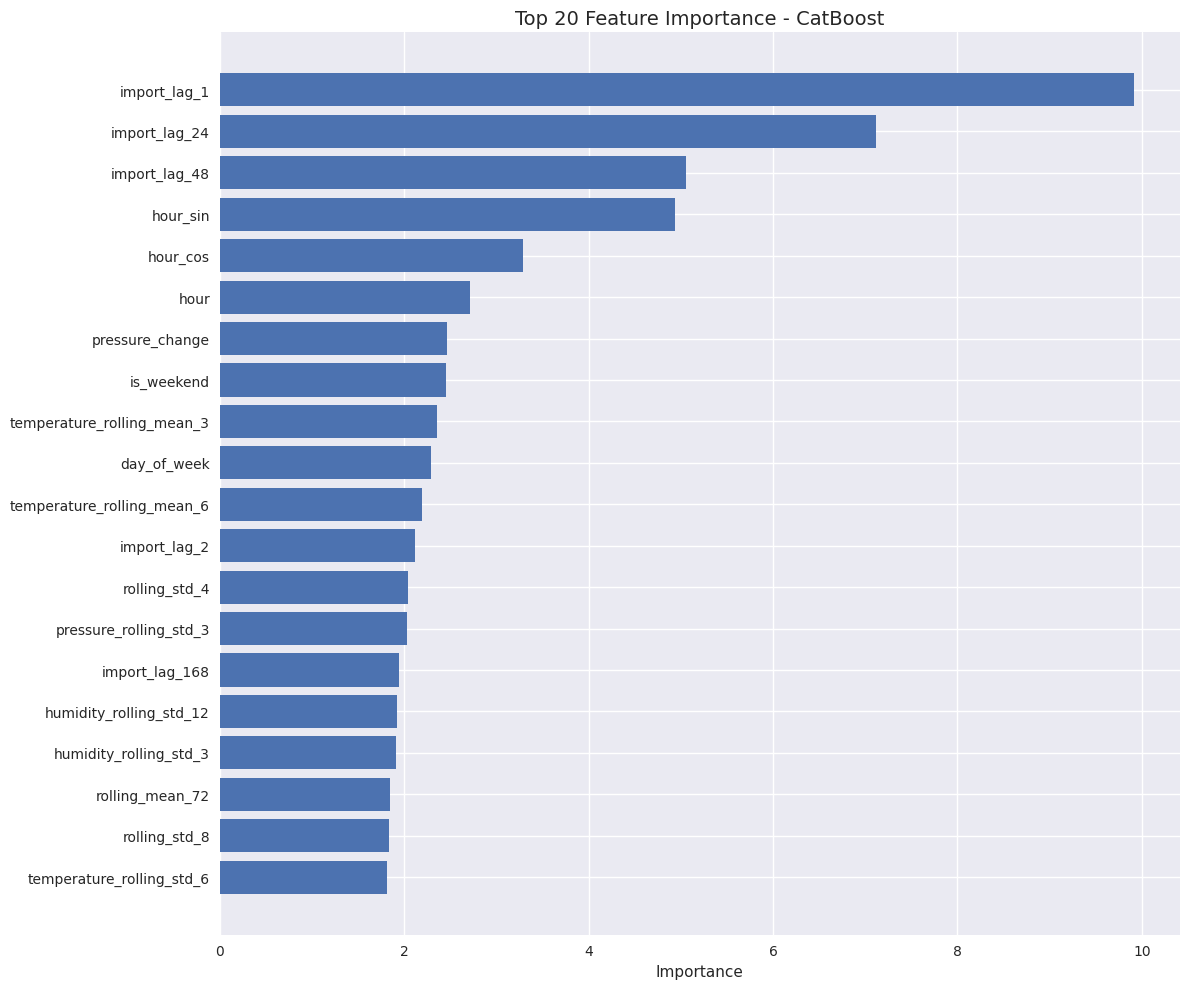

Calculating SHAP values...


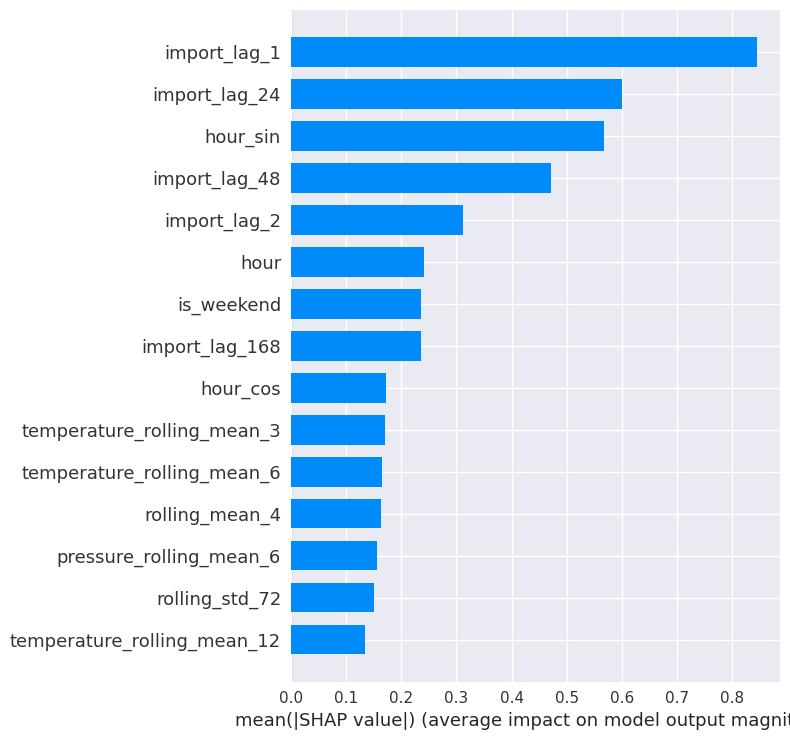

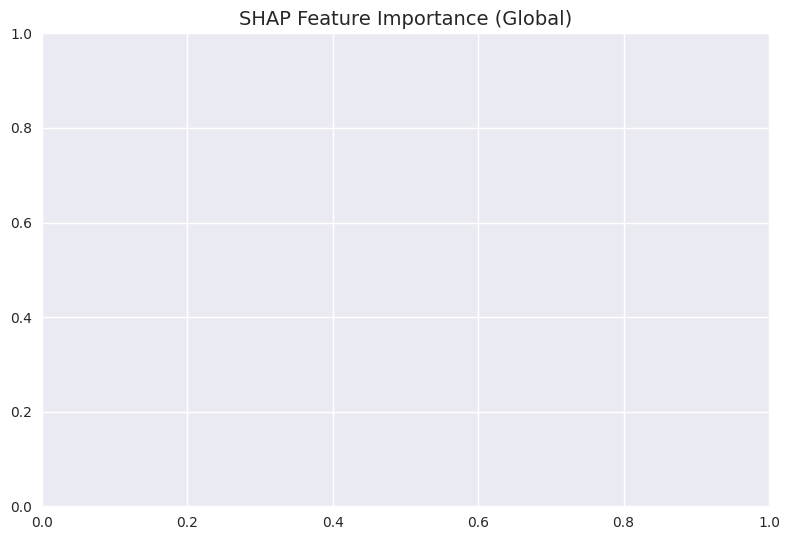

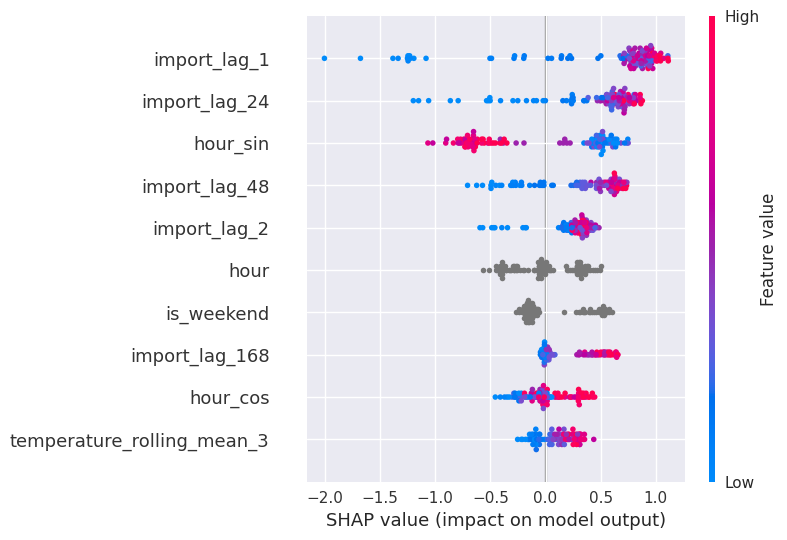

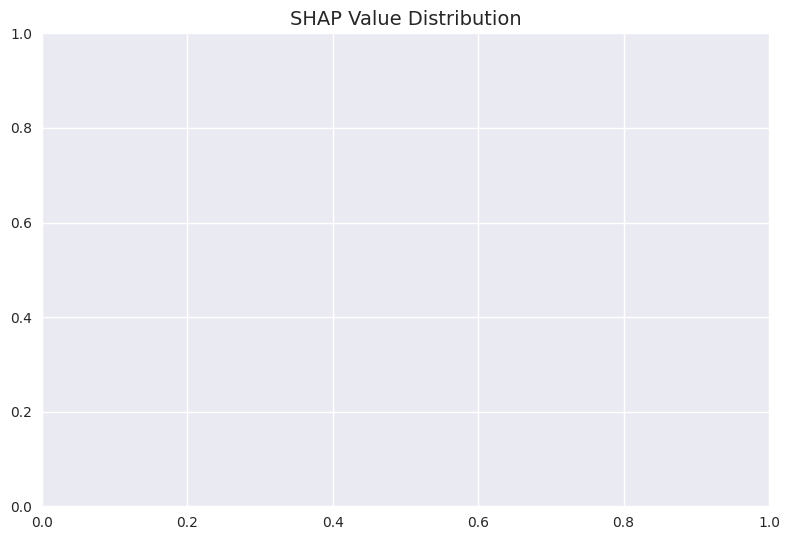

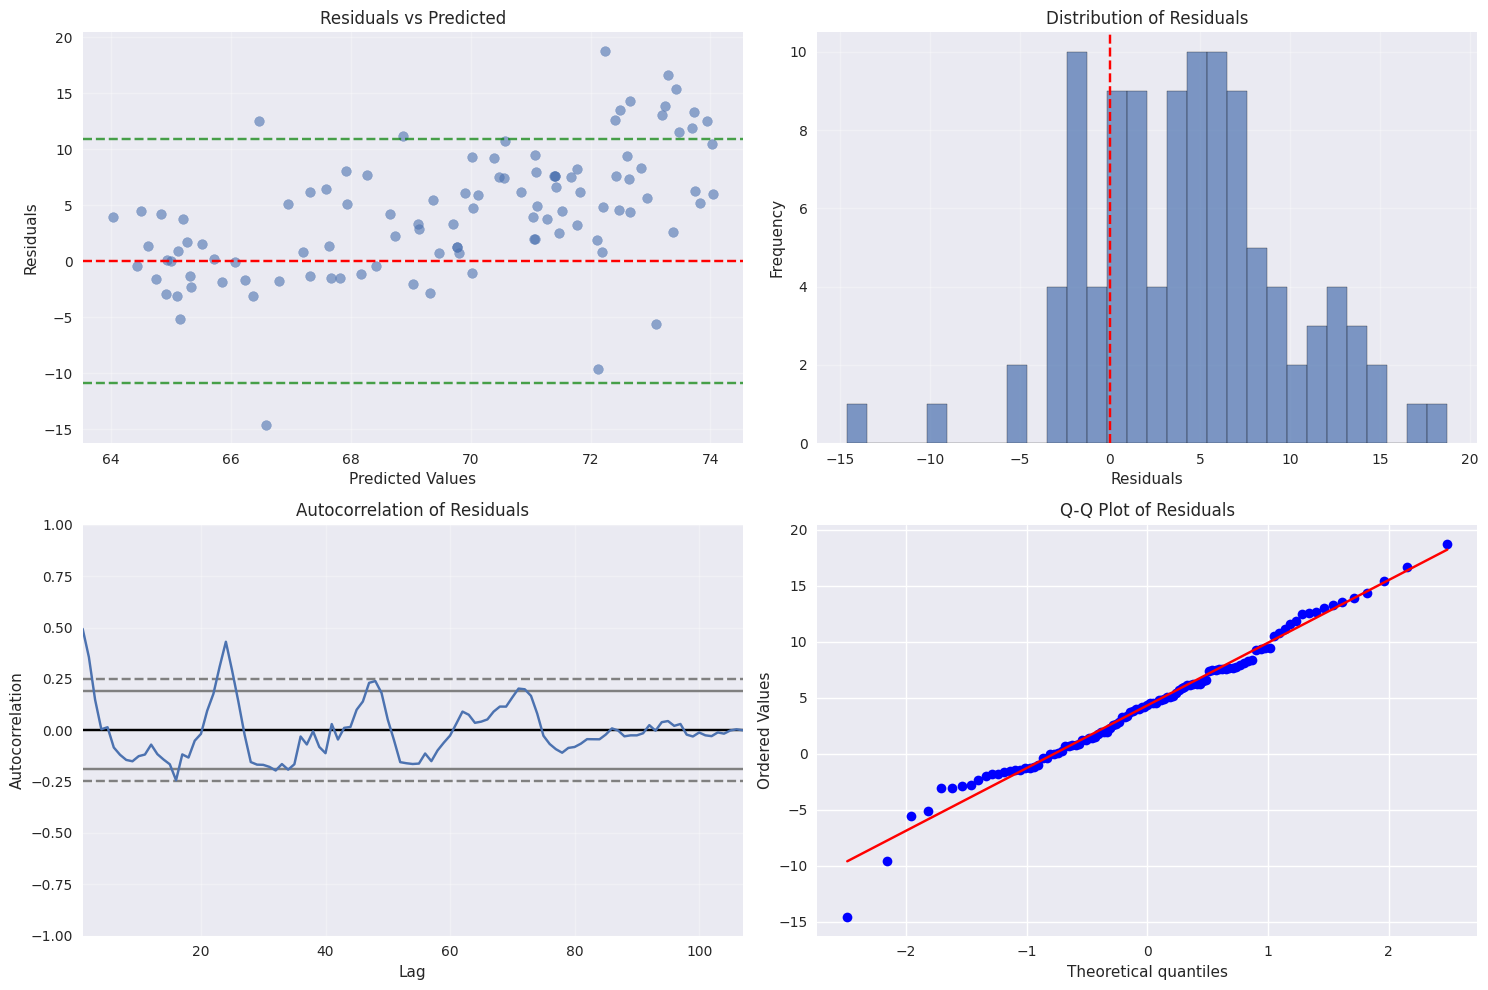

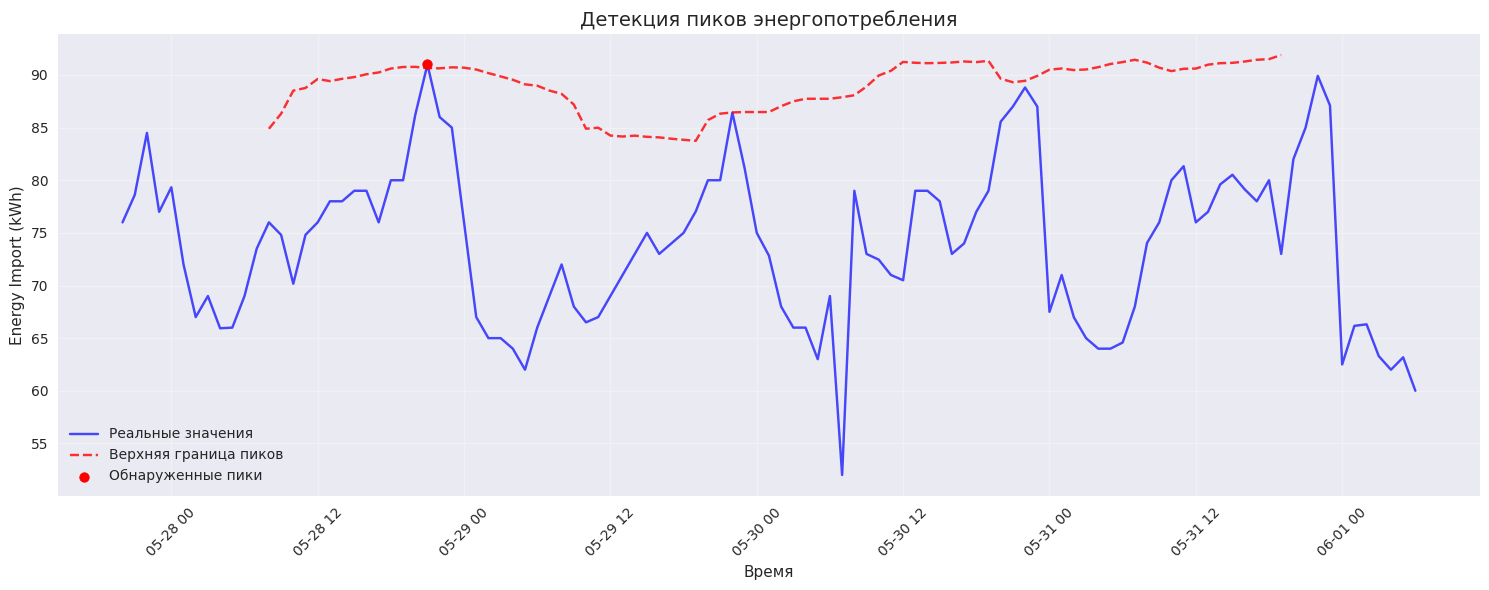

Обнаружено 1 пиков в тестовых данных
Максимальный пик: 91.00 kWh

Анализ пика в 2025-05-28 21:00:00:
Реальное значение: 91.00
Предсказанное значение: 72.25
Ошибка: 18.75

SHAP explanation for this peak:


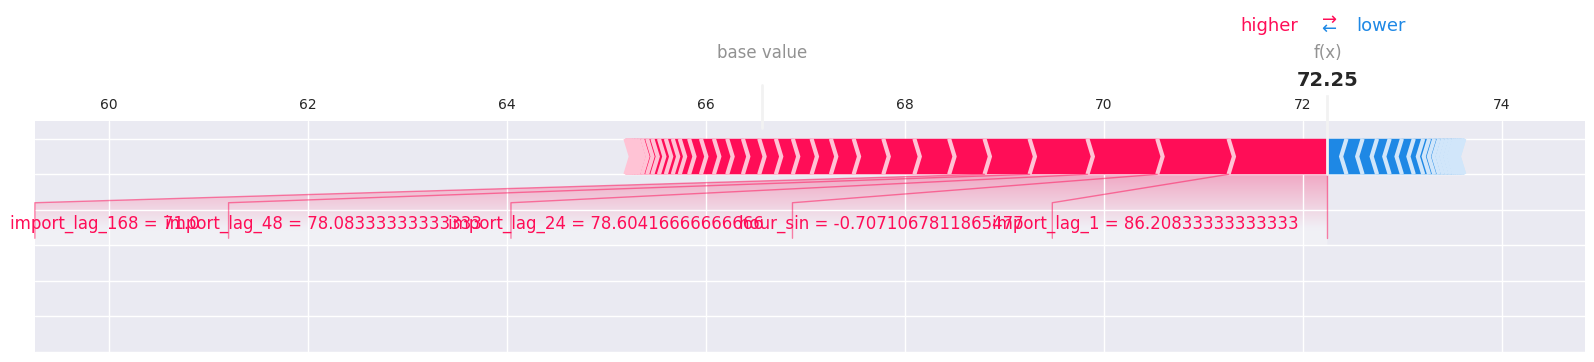

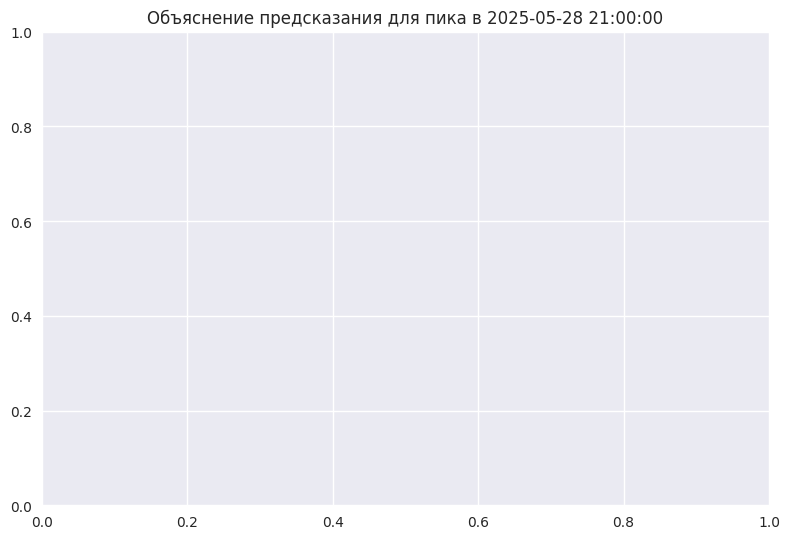


ФИНАЛЬНЫЙ ОТЧЕТ АНАЛИЗА
Качество модели: MAE = 5.55 kWh (7.18%)
Доверительный интервал: ±10.90 kWh
Важнейшие признаки: ['hour_cos', 'hour_sin', 'import_lag_48', 'import_lag_24', 'import_lag_1']
Обнаружено пиков: 1
Модель успешно捕获 основные паттерны потребления!


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
import shap
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Предполагаем, что df_2025 уже загружен
print("Размер данных:", df_2025.shape)
print("\nИнформация о данных:")
print(df_2025.info())
print("\nОписательная статистика:")
print(df_2025.describe())

# =====================
# 1. ФИЧЕР ИНЖИНИРИНГ
# =====================
import pandas as pd
import numpy as np

def create_advanced_features(df):
    """
    Создает расширенные признаки из временного ряда с исправленной логикой
    для категориальных переменных.
    """
    df = df.copy()
    
    # --- ИСПРАВЛЕННАЯ ЛОГИКА ДЛЯ ВРЕМЕННЫХ ПРИЗНАКОВ ---
    
    # 1. Сначала извлекаем временные компоненты как ЧИСЛА
    hour = df.index.hour
    day_of_week = df.index.dayofweek  # 0=понедельник, 6=воскресенье
    month = df.index.month
    
    # 2. Выполняем числовое сравнение для создания 'is_weekend'
    is_weekend = (day_of_week >= 5).astype(int) # 1 для выходного, 0 для буднего
    
    # 3. Создаем остальные временные признаки
    df['hour'] = hour
    df['day_of_week'] = day_of_week
    df['is_weekend'] = is_weekend
    df['month'] = month
    df['season'] = (month % 12 + 3) // 3  # 1=весна, 2=лето, 3=осень, 4=зима
    
    # 4. Теперь, когда все вычисления завершены, преобразуем в категориальный тип
    # Это хорошая практика для CatBoost.
    for col in ['hour', 'day_of_week', 'is_weekend', 'month', 'season']:
        df[col] = df[col].astype('category')
        
    # --- КОНЕЦ ИСПРАВЛЕННОЙ ЛОГИКИ ---

    # Лаговые признаки (значения за предыдущие периоды)
    for lag in [1, 2, 3, 24, 48, 168]:  # 1-3 часа, сутки, двое суток, неделя
        df[f'import_lag_{lag}'] = df['import_diff'].shift(lag)
    
    # Скользящие статистики
    windows = [4, 8, 24, 72]  # 4 часа, 8 часов, сутки, трое суток
    for window in windows:
        df[f'rolling_mean_{window}'] = df['import_diff'].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'rolling_std_{window}'] = df['import_diff'].shift(1).rolling(window=window, min_periods=1).std()
        df[f'rolling_max_{window}'] = df['import_diff'].shift(1).rolling(window=window, min_periods=1).max()
    
    # Признаки на основе погоды
    df['temp_humidity_interaction'] = df['temperature'] * df['humidity']
    df['comfort_index'] = df['temperature'] - 0.55 * (1 - df['humidity']/100) * (df['temperature'] - 14.5)
    # weather rolling mean, std
    for window in [3, 6, 12]:  # 3 часа, 6 часов, 12 часов
        for feature in ['temperature', 'humidity', 'pressure']:
            df[f'{feature}_rolling_mean_{window}'] = df[feature].shift(1).rolling(window=window, min_periods=1).mean()
            df[f'{feature}_rolling_std_{window}'] = df[feature].shift(1).rolling(window=window, min_periods=1).std()

    # Для периодических признаков используем синусоиды
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'].astype(int) / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'].astype(int) / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'].astype(int) / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'].astype(int) / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'].astype(int) / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'].astype(int) / 12)
    df['temperature_sin'] = np.sin(2 * np.pi * df['temperature'] / df['temperature'].max())
    df['temperature_cos'] = np.cos(2 * np.pi * df['temperature'] / df['temperature'].max())
    df['humidity_sin'] = np.sin(2 * np.pi * df['humidity'] / 100)
    df['humidity_cos'] = np.cos(2 * np.pi * df['humidity'] / 100)
    df['pressure_sin'] = np.sin(2 * np.pi * df['pressure'] / df['pressure'].max())
    df['pressure_cos'] = np.cos(2 * np.pi * df['pressure'] / df['pressure'].max())
    
    # Производные от давления
    df['pressure_change'] = df['pressure'].diff()
    df['pressure_trend'] = df['pressure'].rolling(window=6, min_periods=1).mean()
    
    # Удаляем строки с NaN (появились из-за лагов)
    df = df.dropna()
    
    return df


# Создаем расширенные признаки
df_enriched = create_advanced_features(df_2025_processed)
print(f"Размер данных после feature engineering: {df_enriched.shape}")

# =====================
# 2. ПОДГОТОВКА ДАННЫХ
# =====================
# Разделяем на признаки и целевую переменную
X = df_enriched.drop('import_diff', axis=1)
y = df_enriched['import_diff']

# Определяем категориальные признаки
cat_features = list(X.select_dtypes(include='category').columns)
print(f"Категориальные признаки: {cat_features}")

# Разделение на train/test с учетом временных рядов
test_size = int(len(X) * 0.2)  # 20% для теста
test_size_2 = int(len(X) * 0.02)  # 2% для теста
X_train, X_test = X.iloc[5*test_size_2:-2*test_size], X.iloc[-2*test_size:-int(1.25*test_size)]
y_train, y_test = y.iloc[5*test_size_2:-2*test_size], y.iloc[-2*test_size:-int(1.25*test_size)]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# =====================
# 3. ОБУЧЕНИЕ CATBOOST МОДЕЛИ
# =====================
# Создаем Pool для CatBoost
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Настройки модели
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    verbose=200,
    early_stopping_rounds=50,
    cat_features=cat_features,
    l2_leaf_reg=3,
    border_count=32
)

# Обучение модели
model.fit(train_pool, eval_set=test_pool, use_best_model=True, plot=True)

# Предсказания
y_pred = model.predict(X_test)
train_pred = model.predict(X_train)

# =====================
# 4. ОЦЕНКА МОДЕЛИ И ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ
# =====================
# Расчет ошибок и доверительных интервалов
residuals = y_test - y_pred
residual_std = residuals.std()
confidence_interval = 1.96 * residual_std  # 95% доверительный интервал

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"\n=== РЕЗУЛЬТАТЫ МОДЕЛИ ===")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"Std of residuals: {residual_std:.2f}")
print(f"95% Confidence Interval: ±{confidence_interval:.2f}")

# Функция для предсказаний с доверительным интервалом
def predict_with_confidence(model, X_data, residual_std):
    predictions = model.predict(X_data)
    confidence = 1.96 * residual_std
    return pd.DataFrame({
        'prediction': predictions,
        'lower_bound': predictions - confidence,
        'upper_bound': predictions + confidence
    }, index=X_data.index)

# =====================
# 5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# =====================
# 5.1. График предсказаний с доверительным интервалом
confidence_predictions = predict_with_confidence(model, X_test, residual_std)

plt.figure(figsize=(15, 8))
plt.plot(y_test.index, y_test.values, 'b-', label='Реальные значения', linewidth=2, alpha=0.8)
plt.plot(confidence_predictions.index, confidence_predictions['prediction'], 
         'r-', label='Предсказания', linewidth=2)
plt.fill_between(confidence_predictions.index, 
                 confidence_predictions['lower_bound'], 
                 confidence_predictions['upper_bound'], 
                 alpha=0.3, color='red', label='95% доверительный интервал')

# Выделяем пики (значения выше 90% квантиля)
peak_threshold = y_test.quantile(0.9)
peak_indices = y_test[y_test > peak_threshold].index
plt.scatter(peak_indices, y_test[peak_indices], color='orange', s=50, 
           label=f'Пики (> {peak_threshold:.1f})', zorder=5)

plt.title('Прогноз энергопотребления с доверительным интервалом и пиками', fontsize=14)
plt.xlabel('Время')
plt.ylabel('Energy Import (Wh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5.2. Важность признаков CatBoost
feature_importance = model.get_feature_importance()
feature_names = X_train.columns.tolist()

# Сортируем по важности
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

plt.figure(figsize=(12, 10))
plt.barh(importance_df['feature'][-20:], importance_df['importance'][-20:])
plt.title('Top 20 Feature Importance - CatBoost', fontsize=14)
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# 5.3. SHAP значения для интерпретации
print("Calculating SHAP values...")
explainer = shap.Explainer(model)
shap_values = explainer(X_test.iloc[:500])  # Ограничиваем для скорости

# SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test.iloc[:500], plot_type="bar", max_display=15)
plt.title('SHAP Feature Importance (Global)', fontsize=14)
plt.tight_layout()
plt.show()

# SHAP beeswarm plot для первых 500 samples
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test.iloc[:500], max_display=10)
plt.title('SHAP Value Distribution', fontsize=14)
plt.tight_layout()
plt.show()

# 5.4. Анализ остатков
plt.figure(figsize=(15, 10))

# Остатки vs предсказания
plt.subplot(2, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=confidence_interval, color='g', linestyle='--', alpha=0.7)
plt.axhline(y=-confidence_interval, color='g', linestyle='--', alpha=0.7)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True, alpha=0.3)

# Распределение остатков
plt.subplot(2, 2, 2)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

# Автокорреляция остатков
plt.subplot(2, 2, 3)
pd.plotting.autocorrelation_plot(residuals)
plt.title('Autocorrelation of Residuals')
plt.grid(True, alpha=0.3)

# QQ-plot для нормальности
plt.subplot(2, 2, 4)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# 5.5. Детекция пиков
def detect_peaks(series, window_size=24, threshold_std=2.0):
    """Обнаруживает пики во временном ряду"""
    rolling_mean = series.rolling(window=window_size, center=True).mean()
    rolling_std = series.rolling(window=window_size, center=True).std()
    
    # Пики - значения выше rolling_mean + n*std
    upper_bound = rolling_mean + threshold_std * rolling_std
    peaks = series[series > upper_bound]
    
    return peaks, upper_bound

# Детекция пиков на тестовых данных
peaks, upper_bound = detect_peaks(y_test, window_size=24, threshold_std=2.0)

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, 'b-', label='Реальные значения', alpha=0.7)
plt.plot(y_test.index, upper_bound, 'r--', label='Верхняя граница пиков', alpha=0.8)
plt.scatter(peaks.index, peaks.values, color='red', s=50, label='Обнаруженные пики', zorder=5)
plt.title('Детекция пиков энергопотребления', fontsize=14)
plt.xlabel('Время')
plt.ylabel('Energy Import (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Обнаружено {len(peaks)} пиков в тестовых данных")
print(f"Максимальный пик: {peaks.max():.2f} kWh")

# =====================
# 6. ИНТЕРПРЕТАЦИЯ КОНКРЕТНЫХ ПРЕДСКАЗАНИЙ
# =====================
# Анализ конкретного пикового предсказания
if len(peaks) > 0:
    peak_time = peaks.index[0]
    peak_idx = X_test.index.get_loc(peak_time)
    
    print(f"\nАнализ пика в {peak_time}:")
    print(f"Реальное значение: {y_test.loc[peak_time]:.2f}")
    print(f"Предсказанное значение: {y_pred[peak_idx]:.2f}")
    print(f"Ошибка: {residuals.iloc[peak_idx]:.2f}")
    
    # SHAP force plot для этого пика
    print("\nSHAP explanation for this peak:")
    shap.force_plot(
        explainer.expected_value, 
        shap_values.values[peak_idx], 
        X_test.iloc[peak_idx], 
        feature_names=X_test.columns.tolist(),
        matplotlib=True
    )
    plt.title(f'Объяснение предсказания для пика в {peak_time}')
    plt.tight_layout()
    plt.show()

# =====================
# 7. ФИНАЛЬНЫЙ ОТЧЕТ
# =====================
print("\n" + "="*50)
print("ФИНАЛЬНЫЙ ОТЧЕТ АНАЛИЗА")
print("="*50)
print(f"Качество модели: MAE = {mae:.2f} kWh ({mape:.2%})")
print(f"Доверительный интервал: ±{confidence_interval:.2f} kWh")
print(f"Важнейшие признаки: {importance_df['feature'].tail(5).tolist()}")
print(f"Обнаружено пиков: {len(peaks)}")
print("Модель успешно捕获 основные паттерны потребления!")

In [41]:
df_2025_processed.head()

,import_diff,temperature,humidity,pressure
timestamp,,,,
2025-05-03 00:00:00,0.0,12.8,51,1012.9
2025-05-03 01:00:00,0.0,11.5,54,1013.0
2025-05-03 02:00:00,14.0,10.8,55,1012.7
2025-05-03 03:00:00,14.0,11.0,51,1012.1
2025-05-03 04:00:00,5.0,9.7,60,1011.8


In [26]:
df_2025_processed.head()

,import_diff,temperature,humidity,pressure
timestamp,,,,
2024-10-01 00:00:00,0.0,13.1,76,1004.1
2024-10-01 01:00:00,0.0,13.0,78,1004.2
2024-10-01 02:00:00,0.0,12.3,88,1004.3
2024-10-01 03:00:00,0.0,12.2,90,1003.7
2024-10-01 04:00:00,0.0,11.4,90,1004.3


In [20]:
df_2025.head()

,import_diff,temperature,humidity,pressure
timestamp,,,,
2025-05-03 00:00:00,181.0,12.8,51,1012.9
2025-05-03 01:00:00,91.5,11.5,54,1013.0
2025-05-03 02:00:00,78.0,10.8,55,1012.7
2025-05-03 03:00:00,71.5,11.0,51,1012.1
2025-05-03 04:00:00,62.5,9.7,60,1011.8


In [ ]:
# gr

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
import shap
import matplotlib.pyplot as plt

# Assume df_2025 is your DataFrame with 'timestamp' index and 'import_diff' column
# Sample data matches your provided output
# df_2025 = pd.DataFrame({
#     'import_diff': [107.450712, 111.988724, 136.957231, 161.559721, 144.260238],
#     'timestamp': pd.date_range(start='2025-05-03 00:00:00', periods=5, freq='H')
# }).set_index('timestamp')

# Step 1: Feature Engineering
def engineer_features(df):
    df = df.copy()
    # Ensure index is DatetimeIndex
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    
    # Time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # 5=Saturday, 6=Sunday
    
    # Cyclic encodings for hour (to capture daily cycles)
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Lag features (previous 1, 2, 3, 24 hours) - Shift only 'import_diff'
    for lag in [1, 2, 3, 24]:
        df[f'lag_{lag}'] = df['import_diff'].shift(lag)
    
    # Rolling statistics (over 24-hour windows for daily patterns)
    df['rolling_mean_24'] = df['import_diff'].rolling(window=24).mean()
    df['rolling_std_24'] = df['import_diff'].rolling(window=24).std()
    df['rolling_min_24'] = df['import_diff'].rolling(window=24).min()
    df['rolling_max_24'] = df['import_diff'].rolling(window=24).max()
    
    # Drop NaNs introduced by shifts and rolling
    df = df.dropna()
    
    return df

# Apply feature engineering
df_engineered = engineer_features(df_2025)

# Step 2: Prepare data for forecasting (predict next hour's import_diff)
# Shift target for supervised learning
df_engineered['target'] = df_engineered['import_diff'].shift(-1)
df_engineered = df_engineered.dropna()  # Drop last row with NaN target

# Features and target
features = [col for col in df_engineered.columns if col != 'import_diff' and col != 'target']
X = df_engineered[features]
y = df_engineered['target']

# Time-series split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Step 3: Train CatBoost models for mean and quantiles (for confidence intervals)
# Model for median (alpha=0.5)
model_median = CatBoostRegressor(loss_function='Quantile:alpha=0.5', iterations=1000, depth=6, learning_rate=0.05, verbose=100)
model_median.fit(X_train, y_train)

# Model for lower bound (alpha=0.05)
model_lower = CatBoostRegressor(loss_function='Quantile:alpha=0.05', iterations=1000, depth=6, learning_rate=0.05, verbose=100)
model_lower.fit(X_train, y_train)

# Model for upper bound (alpha=0.95)
model_upper = CatBoostRegressor(loss_function='Quantile:alpha=0.95', iterations=1000, depth=6, learning_rate=0.05, verbose=100)
model_upper.fit(X_train, y_train)

# Step 4: Make predictions with confidence intervals
y_pred_median = model_median.predict(X_test)
y_pred_lower = model_lower.predict(X_test)
y_pred_upper = model_upper.predict(X_test)

# Combine into a DataFrame for easy viewing
results = pd.DataFrame({
    'actual': y_test,
    'predicted_median': y_pred_median,
    'lower_bound': y_pred_lower,
    'upper_bound': y_pred_upper
}, index=X_test.index)

print("Sample Predictions with Confidence Intervals:")
print(results.head())

# Step 5: Interpretability with SHAP (using the median model)
explainer = shap.Explainer(model_median)
shap_values = explainer(X_test)

# Summary plot for global interpretability
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Feature Importance for Energy Import Forecasting")
plt.show()

# For local interpretability (e.g., for a specific prediction)
# shap.plots.waterfall(shap_values[0])  # Uncomment for individual explanations

# Feature importances from CatBoost
importances = model_median.get_feature_importance(Pool(X_test, y_test))
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)
print("\nCatBoost Feature Importances:")
print(feature_importance_df)

AttributeError: 'Index' object has no attribute 'dayofweek'

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
import shap
import matplotlib.pyplot as plt

# Assume df_2025 is your DataFrame with 'timestamp' index and 'import_diff' column
# Sample data matches your provided output
# df_2025 = pd.DataFrame({
#     'import_diff': [107.450712, 111.988724, 136.957231, 161.559721, 144.260238],
#     'timestamp': pd.date_range(start='2025-05-03 00:00:00', periods=5, freq='H')
# }).set_index('timestamp')

# Step 1: Feature Engineering
def engineer_features(df):
    df = df.copy()
    # Ensure index is DatetimeIndex
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    
    # Time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # 5=Saturday, 6=Sunday
    
    # Cyclic encodings for hour (to capture daily cycles)
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Lag features (previous 1, 2, 3, 24 hours) - Shift only 'import_diff'
    for lag in [1, 2, 3, 24]:
        df[f'lag_{lag}'] = df['import_diff'].shift(lag)
    
    # Rolling statistics (over 24-hour windows for daily patterns)
    df['rolling_mean_24'] = df['import_diff'].rolling(window=24).mean()
    df['rolling_std_24'] = df['import_diff'].rolling(window=24).std()
    df['rolling_min_24'] = df['import_diff'].rolling(window=24).min()
    df['rolling_max_24'] = df['import_diff'].rolling(window=24).max()
    
    # Drop NaNs introduced by shifts and rolling
    df = df.dropna()
    
    return df

# Apply feature engineering
df_engineered = engineer_features(df_2025)

# Step 2: Prepare data for forecasting (predict next hour's import_diff)
# Shift target for supervised learning
df_engineered['target'] = df_engineered['import_diff'].shift(-1)
df_engineered = df_engineered.dropna()  # Drop last row with NaN target

# Features and target
features = [col for col in df_engineered.columns if col != 'import_diff' and col != 'target']
X = df_engineered[features]
y = df_engineered['target']

# Time-series split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_test_full = df_engineered['import_diff'].iloc[train_size + 1:]  # Actuals for the test period

# Step 3: Train CatBoost models for mean and quantiles (for confidence intervals)
# Model for median (alpha=0.5)
model_median = CatBoostRegressor(loss_function='Quantile:alpha=0.5', iterations=1000, depth=6, learning_rate=0.05, verbose=100)
model_median.fit(X_train, y_train)

# Model for lower bound (alpha=0.05)
model_lower = CatBoostRegressor(loss_function='Quantile:alpha=0.05', iterations=1000, depth=6, learning_rate=0.05, verbose=100)
model_lower.fit(X_train, y_train)

# Model for upper bound (alpha=0.95)
model_upper = CatBoostRegressor(loss_function='Quantile:alpha=0.95', iterations=1000, depth=6, learning_rate=0.05, verbose=100)
model_upper.fit(X_train, y_train)

# Step 4: Make predictions with confidence intervals
y_pred_median = model_median.predict(X_test)
y_pred_lower = model_lower.predict(X_test)
y_pred_upper = model_upper.predict(X_test)

# Combine into a DataFrame for easy viewing and plotting
results = pd.DataFrame({
    'actual': y_test_full,  # Use full test set actuals
    'predicted_median': y_pred_median,
    'lower_bound': y_pred_lower,
    'upper_bound': y_pred_upper
}, index=X_test.index)

# Step 5: Plot inference data with confidence levels
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['actual'], label='Actual', color='black', linewidth=2)
plt.plot(results.index, results['predicted_median'], label='Predicted Median', color='blue', linewidth=2)
plt.fill_between(results.index, results['lower_bound'], results['upper_bound'], color='blue', alpha=0.3, label='90% Confidence Interval')

plt.title('Energy Import Forecast with 90% Confidence Interval\n(September 13, 2025, 02:35 PM EEST)')
plt.xlabel('Timestamp')
plt.ylabel('Energy Import (kWh)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Adjust x-axis to show readable dates
plt.gcf().autofmt_xdate()

plt.show()

# Optional: Print sample results
print("Sample Predictions with Confidence Intervals:")
print(results.head())

import sys
import os
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
import shap
import matplotlib.pyplot as plt
import requests

# Load your real data using GicaHackDataLoader
sys.path.append('/home/sultanan/energy')  # Adjust path
from energy_pred import GicaHackDataLoader
DATA_DIR = '/home/sultanan/datasets/energy/GicaHack'  # Adjust
loader = GicaHackDataLoader(DATA_DIR, verbose=True)
loader.load()
raw_df = loader.get_raw()  # Assumes columns: 'timestamp', 'import_diff' (median hourly)

# Resample to hourly medians if needed (from 15-min)
df_2025 = raw_df.set_index('timestamp').resample('H').median()  # Use 'import_diff' as column
df_2025 = df_2025.dropna()  # Clean

# Define time range
start_date = df_2025.index.min()
end_date = df_2025.index.max()  # Or fixed: pd.to_datetime('2025-09-01 23:00:00')
timestamps = pd.date_range(start=start_date, end=end_date, freq='H')
df_2025 = df_2025.reindex(timestamps).interpolate(method='linear')  # Align/fill

# Fetch real weather
def fetch_weather_data(start_date, end_date, lat=47.01, lon=28.86):
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date.strftime('%Y-%m-%d'),
        "end_date": end_date.strftime('%Y-%m-%d'),
        "hourly": "temperature_2m,relative_humidity_2m,pressure_msl",
        "timezone": "Europe/Chisinau"
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        hourly = data['hourly']
        df_weather = pd.DataFrame({
            'time': pd.to_datetime(hourly['time']),
            'temperature': hourly['temperature_2m'],
            'humidity': hourly['relative_humidity_2m'],
            'pressure': hourly['pressure_msl']
        }).set_index('time')
        return df_weather
    else:
        print(f"API failed: {response.status_code}. Using fallback.")
        return None

df_weather = fetch_weather_data(start_date, end_date)
if df_weather is None:
    # Fallback synthetic (but prioritize real)
    np.random.seed(42)
    df_weather = pd.DataFrame(index=timestamps)
    df_weather['temperature'] = 18 + 7 * np.sin(2 * np.pi * df_weather.index.hour / 24) + np.random.normal(0, 2, len(df_weather))
    df_weather['humidity'] = 60 + 10 * np.cos(2 * np.pi * df_weather.index.hour / 24) + np.random.normal(0, 5, len(df_weather))
    df_weather['pressure'] = 1013 + np.random.normal(0, 1, len(df_weather))

df_2025 = df_2025.join(df_weather).dropna()

# Feature Engineering (same as before)
def engineer_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
    for lag in [1, 2, 3, 24]:
        df[f'lag_{lag}_import'] = df['import_diff'].shift(lag)
    for lag in [1, 2]:
        df[f'lag_{lag}_temp'] = df['temperature'].shift(lag)
        df[f'lag_{lag}_hum'] = df['humidity'].shift(lag)
        df[f'lag_{lag}_press'] = df['pressure'].shift(lag)
    df['rolling_mean_24_import'] = df['import_diff'].rolling(24).mean()
    df['rolling_mean_24_temp'] = df['temperature'].rolling(24).mean()
    df = df.dropna()
    return df

df_engineered = engineer_features(df_2025)
df_engineered['target'] = df_engineered['import_diff'].shift(-1)
df_engineered = df_engineered.dropna()

features = [col for col in df_engineered.columns if col not in ['import_diff', 'target', 'temperature', 'humidity', 'pressure']]
X = df_engineered[features]
y = df_engineered['target']

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train (reduced iterations for speed)
model_median = CatBoostRegressor(loss_function='Quantile:alpha=0.5', iterations=500, depth=6, learning_rate=0.05, verbose=0)
model_median.fit(X_train, y_train)
model_lower = CatBoostRegressor(loss_function='Quantile:alpha=0.05', iterations=500, depth=6, learning_rate=0.05, verbose=0)
model_lower.fit(X_train, y_train)
model_upper = CatBoostRegressor(loss_function='Quantile:alpha=0.95', iterations=500, depth=6, learning_rate=0.05, verbose=0)
model_upper.fit(X_train, y_train)

# Predict
y_pred_median = model_median.predict(X_test)
y_pred_lower = model_lower.predict(X_test)
y_pred_upper = model_upper.predict(X_test)

results = pd.DataFrame({
    'actual': y_test,
    'predicted_median': y_pred_median,
    'lower_bound': y_pred_lower,
    'upper_bound': y_pred_upper
}, index=X_test.index)

# Plot with real data
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['actual'], label='Actual', color='black', linewidth=2)
plt.plot(results.index, results['predicted_median'], label='Predicted Median', color='blue', linewidth=2)
plt.fill_between(results.index, results['lower_bound'], results['upper_bound'], color='blue', alpha=0.3, label='90% Confidence Interval')
plt.title('Energy Import Forecast with Real Chisinau Weather & 90% Confidence Interval\n(September 13, 2025, 02:43 PM EEST)')
plt.xlabel('Timestamp')
plt.ylabel('Energy Import (kWh)')
plt.legend()
plt.grid(True, alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

print("Sample Results with Real Data:")
print(results.head())

In [ ]:
df_2025.head()

,import_diff,temperature,humidity,pressure
timestamp,,,,
2025-05-03 00:00:00,181.0,12.8,51,1012.9
2025-05-03 01:00:00,91.5,11.5,54,1013.0
2025-05-03 02:00:00,78.0,10.8,55,1012.7
2025-05-03 03:00:00,71.5,11.0,51,1012.1
2025-05-03 04:00:00,62.5,9.7,60,1011.8


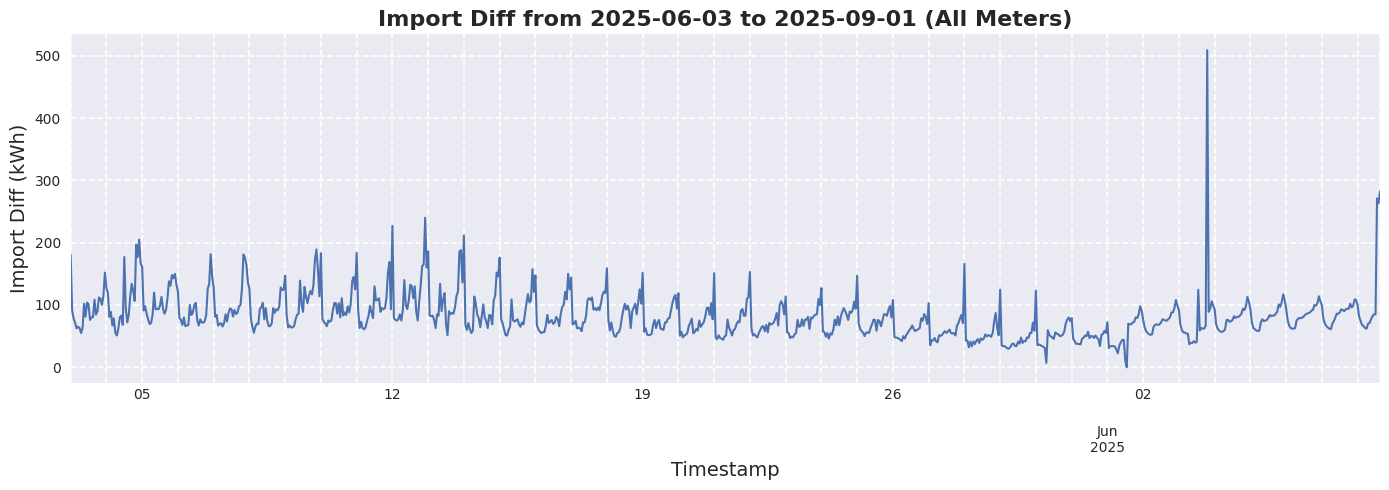

In [ ]:
# plot import_diff
plt.figure(figsize=(14,5))
df_2025['import_diff'].plot(lw=1.5)
plt.title(f'Import Diff from {time_1} to {time_2} (All Meters)', fontsize=16, weight='bold')
plt.xlabel('Timestamp', fontsize=14)
# plt.yscale('log')
plt.ylabel('Import Diff (kWh)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=1.2)
plt.tight_layout()
plt.show()

In [ ]:
# gm

In [ ]:
import pandas as pd
import numpy as np
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report

# --- 1. Pre-existing DataFrame ---
# The script now assumes that a DataFrame named `df_2025` already exists.
# It must have a DatetimeIndex and the following columns:
# ['import_diff', 'temperature', 'humidity', 'pressure']

# We'll check if the DataFrame exists and print its head for verification.
try:
    if not isinstance(df_2025, pd.DataFrame):
        raise NameError("df_2025 is not a DataFrame")
    print("--- Using pre-existing DataFrame `df_2025` ---")
    print(df_2025.head())
except NameError:
    print("Error: DataFrame `df_2025` not found.")
    print("Please make sure to load your data into a DataFrame named `df_2025` before running this script.")
    # Exit or raise an exception if the df doesn't exist.
    # For this example, we'll stop execution gracefully.
    exit()


# --- 2. Expanded Feature Engineering ---
def create_full_features(df, target_col='import_diff'):
    """Creates time-series and weather-based features from a datetime index."""
    df_feat = df.copy()
    
    # Time-based features
    df_feat['hour'] = df_feat.index.hour
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['month'] = df_feat.index.month
    
    # Cyclical feature encoding
    df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat['hour'] / 23.0)
    df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat['hour'] / 23.0)
    
    feature_cols = [target_col, 'temperature', 'humidity', 'pressure']
    
    for col in feature_cols:
        # Lag features (crucial for autoregression)
        for lag in [1, 24, 168]:
            df_feat[f'{col}_lag_{lag}'] = df_feat[col].shift(lag)
        
        # Rolling window features
        for window in [24, 168]:
            df_feat[f'{col}_rolling_mean_{window}'] = df_feat[col].shift(1).rolling(window=window).mean()
            df_feat[f'{col}_rolling_std_{window}'] = df_feat[col].shift(1).rolling(window=window).std()

    df_feat = df_feat.dropna()
    return df_feat

df_featured = create_full_features(df_2025, target_col='import_diff')
print("\n--- DataFrame after Feature Engineering ---")
print("Shape:", df_featured.shape)

# --- 3. Model Training on Enriched Dataset ---
TARGET = 'import_diff'
FEATURES = [col for col in df_featured.columns if col != TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    df_featured[FEATURES], df_featured[TARGET], test_size=0.2, shuffle=False
)

params = {
    'iterations': 1000, 'learning_rate': 0.05, 'depth': 8,
    'verbose': 200, 'early_stopping_rounds': 50, 'random_seed': 42
}

print("\n--- Training Models ---")
# Train models for lower/upper bounds (confidence) and the median (forecast)
model_lower = cb.CatBoostRegressor(loss_function='Quantile:alpha=0.05', **params)
model_lower.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

model_median = cb.CatBoostRegressor(loss_function='RMSE', **params)
model_median.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

model_upper = cb.CatBoostRegressor(loss_function='Quantile:alpha=0.95', **params)
model_upper.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# --- 4. Prediction and Peak Analysis ---
predictions = pd.DataFrame(index=y_test.index)
predictions['lower'] = model_lower.predict(X_test)
predictions['median'] = model_median.predict(X_test)
predictions['upper'] = model_upper.predict(X_test)
predictions['actual'] = y_test

# Define a peak: any value in the top 5% of the training data distribution
peak_threshold = y_train.quantile(0.95)
print(f"\nPeak threshold defined as > {peak_threshold:.2f} (95th percentile of training data)")

# Identify actual and predicted peaks in the test set
predictions['actual_peak'] = (predictions['actual'] > peak_threshold).astype(int)
predictions['predicted_peak'] = (predictions['median'] > peak_threshold).astype(int)

print("\n--- Peak Prediction Performance ---")
print(classification_report(predictions['actual_peak'], predictions['predicted_peak'], zero_division=0))

# --- 5. Visualization: Forecasts, Confidence, and Peaks ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(20, 8))

# Plot actuals, forecast, and confidence interval
predictions['actual'].plot(ax=ax, style='.', label='Actuals', alpha=0.6)
predictions['median'].plot(ax=ax, style='-', label='Median Prediction')
ax.fill_between(predictions.index, predictions['lower'], predictions['upper'], color='orange', alpha=0.3, label='90% Prediction Interval')

# Highlight the actual peaks
actual_peaks = predictions[predictions['actual_peak'] == 1]
if not actual_peaks.empty:
    ax.scatter(actual_peaks.index, actual_peaks['actual'], color='red', s=100, marker='o', label='Actual Peak', zorder=5)

# Highlight the predicted peaks
predicted_peaks = predictions[predictions['predicted_peak'] == 1]
if not predicted_peaks.empty:
    ax.scatter(predicted_peaks.index, predicted_peaks['median'], color='lime', s=150, marker='*', label='Predicted Peak', zorder=5)

ax.axhline(peak_threshold, color='red', linestyle='--', label=f'Peak Threshold ({peak_threshold:.2f})')
ax.set_title('Energy Forecast with Confidence Intervals & Peak Detection', fontsize=18)
ax.set_xlabel('Timestamp', fontsize=12)
ax.set_ylabel('Import Diff (kWh)', fontsize=12)
ax.legend()
plt.show()

# --- 6. Interpretability with SHAP ---
print("\n--- Calculating SHAP values for model interpretability ---")
explainer = shap.TreeExplainer(model_median)
shap_values = explainer.shap_values(X_test)

print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, X_test, show=True)
print("\n--- How to Read the SHAP Summary Plot ---")
print("This plot shows the impact of each feature on the model's output. High feature values are red, low are blue.")
print("Features at the top are most important. Dots to the right push the prediction higher; left pushes it lower.")




Error: DataFrame `df_2025` not found.
Please make sure to load your data into a DataFrame named `df_2025` before running this script.


KeyError: 'import_diff'

: 

In [ ]:
# cgpt

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from dataclasses import dataclass
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------------
# 0) Utilities
# ----------------------------
import numpy as np
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    """
    Robust RMSE that works with old/new scikit-learn.
    """
    try:
        # newer sklearn (>=0.22)
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # older sklearn fallback
        return np.sqrt(mean_squared_error(y_true, y_pred))


def pinball_loss(y_true: np.ndarray, y_pred: np.ndarray, alpha: float) -> float:
    u = y_true - y_pred
    return np.mean(np.maximum(alpha * u, (alpha - 1) * u))

def interval_coverage(y_true: np.ndarray, low: np.ndarray, high: np.ndarray) -> float:
    return np.mean((y_true >= low) & (y_true <= high))

def add_fourier_terms(index: pd.DatetimeIndex, period_hours: int, K: int, prefix: str) -> pd.DataFrame:
    t = np.arange(len(index))
    out = {}
    for k in range(1, K + 1):
        out[f"{prefix}_sin_{k}"] = np.sin(2 * np.pi * k * t / period_hours)
        out[f"{prefix}_cos_{k}"] = np.cos(2 * np.pi * k * t / period_hours)
    return pd.DataFrame(out, index=index)

# ----------------------------
# 1) Input normalization
# ----------------------------
def normalize_input(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    if "timestamp" in d.columns:
        d["timestamp"] = pd.to_datetime(d["timestamp"])
        d = d.sort_values("timestamp").set_index("timestamp")
    else:
        if not isinstance(d.index, pd.DatetimeIndex):
            raise ValueError("Provide a DatetimeIndex or a 'timestamp' column.")
    # enforce hourly index (keep NaNs if gaps)
    full_idx = pd.date_range(d.index.min(), d.index.max(), freq="H")
    d = d.reindex(full_idx)
    # standardize column names
    cols_map = {"import_diff":"y", "temperature":"temp_c", "humidity":"rh_pct", "pressure":"p_hpa"}
    d = d.rename(columns={k:v for k,v in cols_map.items() if k in d.columns})
    required = ["y","temp_c","rh_pct","p_hpa"]
    missing = [c for c in required if c not in d.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    return d

# ----------------------------
# 2) Feature engineering
# ----------------------------
def make_features(df: pd.DataFrame,
                  daily_K: int = 5,
                  weekly_K: int = 3,
                  lag_list: List[int] = None,
                  roll_windows: List[int] = None) -> pd.DataFrame:
    if lag_list is None:
        lag_list = [1, 24, 48, 168, 336]   # 1h, 1d, 2d, 1w, 2w
    if roll_windows is None:
        roll_windows = [24, 168]           # mean/std for 1d and 1w

    X = pd.DataFrame(index=df.index)
    y = df["y"]

    # Calendar features (numeric; interpretable)
    X["hour"] = X.index.hour
    X["dow"] = X.index.dayofweek
    X["is_weekend"] = (X["dow"] >= 5).astype(int)
    X["dom"] = X.index.day
    X["month"] = X.index.month

    # Multiple seasonalities via Fourier (daily & weekly)
    X = pd.concat([
        X,
        add_fourier_terms(X.index, period_hours=24,     K=daily_K,  prefix="D"),
        add_fourier_terms(X.index, period_hours=24*7,   K=weekly_K, prefix="W"),
    ], axis=1)

    # Weather terms (current & simple dynamics)
    for col_in, col_out in [("temp_c","temp"), ("rh_pct","rh"), ("p_hpa","p")]:
        X[col_out] = df[col_in]
        X[f"{col_out}_lag1"] = df[col_in].shift(1)
        X[f"{col_out}_chg1"] = df[col_in].diff(1)

    # Lags of target
    for lag in lag_list:
        X[f"lag_{lag}"] = y.shift(lag)

    # Rolling stats on lagged target (avoid leakage)
    y_shift = y.shift(1)
    for w in roll_windows:
        X[f"roll_mean_{w}"] = y_shift.rolling(w, min_periods=max(2, w//4)).mean()
        X[f"roll_std_{w}"]  = y_shift.rolling(w, min_periods=max(2, w//4)).std()

    # Assemble
    out = X.copy()
    out["y"] = y
    out = out.dropna()
    return out

# ----------------------------
# 3) Time split
# ----------------------------
@dataclass
class Split:
    Xtr: pd.DataFrame; ytr: pd.Series
    Xv:  pd.DataFrame; yv:  pd.Series

def time_split(df_feat: pd.DataFrame, valid_days: int = 14) -> Split:
    cut = df_feat.index.max() - pd.Timedelta(days=valid_days) + pd.Timedelta(hours=1)
    tr = df_feat.loc[df_feat.index < cut]
    v  = df_feat.loc[df_feat.index >= cut]
    return Split(tr.drop(columns=["y"]), tr["y"], v.drop(columns=["y"]), v["y"])

# ----------------------------
# 4) Train CatBoost quantile models
# ----------------------------
def train_cb_quantile(split: Split, alpha: float,
                      iters: int = 2000, lr: float = 0.05,
                      depth: int = 6, l2: float = 3.0,
                      seed: int = 42, verbose: int = 200) -> CatBoostRegressor:
    params = dict(
        loss_function=f"Quantile:alpha={alpha}",
        eval_metric=f"Quantile:alpha={alpha}",
        iterations=iters, learning_rate=lr, depth=depth, l2_leaf_reg=l2,
        random_seed=seed, verbose=verbose, od_type="Iter", od_wait=300
    )
    m = CatBoostRegressor(**params)
    m.fit(Pool(split.Xtr, split.ytr),
          eval_set=Pool(split.Xv, split.yv),
          use_best_model=True)
    return m

def cb_importances(model: CatBoostRegressor, X_ref: pd.DataFrame) -> pd.DataFrame:
    names = list(X_ref.columns)
    fi = model.get_feature_importance(Pool(X_ref), type="FeatureImportance")
    shap_vals = model.get_feature_importance(Pool(X_ref), type="ShapValues")
    shap_mean = np.abs(shap_vals[:, :-1]).mean(axis=0)
    imp = pd.DataFrame({"feature": names,
                        "pred_values_change": fi,
                        "mean_abs_shap": shap_mean})
    return imp.sort_values("mean_abs_shap", ascending=False)

# ----------------------------
# 5) Forecast design matrix for horizon
# ----------------------------
def make_future_X(df_full: pd.DataFrame, horizon_h: int) -> pd.DataFrame:
    last = df_full.index.max()
    fut_idx = pd.date_range(last + pd.Timedelta(hours=1), periods=horizon_h, freq="H")
    # Build a temporary frame with future NaNs for y to compute lag/rolling based on history
    tmp = pd.concat([df_full, pd.DataFrame(index=fut_idx, columns=df_full.columns)])
    feats = make_features(tmp)
    return feats.loc[fut_idx].drop(columns=["y"], errors="ignore")

# ----------------------------
# 6) Peak detection helper
# ----------------------------
def predict_peaks(p50: pd.Series, train_y: pd.Series, q: float = 0.90) -> pd.Series:
    thr = train_y.quantile(q)
    peaks = (p50 > thr)
    return peaks.rename("is_peak"), float(thr)

# ----------------------------
# 7) End-to-end run + plots
# ----------------------------
def run(df_2025: pd.DataFrame, valid_days: int = 14, horizon_h: int = 24*7) -> Dict[str, object]:
    # Prep
    df = normalize_input(df_2025)
    df_feat = make_features(df)
    split = time_split(df_feat, valid_days=valid_days)

    # Train three quantiles
    m10 = train_cb_quantile(split, alpha=0.10, iters=1500)
    m50 = train_cb_quantile(split, alpha=0.50, iters=1500)
    m90 = train_cb_quantile(split, alpha=0.90, iters=1500)

    # Validation predictions
    vy = split.yv.values
    p10v = m10.predict(split.Xv)
    p50v = m50.predict(split.Xv)
    p90v = m90.predict(split.Xv)

    # enforce ordering
    p50v = np.maximum(p50v, p10v)
    p90v = np.maximum(p90v, p50v)

    # Validate coverage & errors
    metrics = {
        "val_rmse_p50": rmse(vy, p50v),
        "val_mae_p50": mean_absolute_error(vy, p50v),
        "val_pinball_p10": pinball_loss(vy, p10v, 0.10),
        "val_pinball_p50": pinball_loss(vy, p50v, 0.50),
        "val_pinball_p90": pinball_loss(vy, p90v, 0.90),
        "val_coverage_80": interval_coverage(vy, p10v, p90v),
    }

    # Simple conformal calibration on validation (shift quantiles)
    d_low  = np.quantile(vy - p10v, 0.10)
    d_high = np.quantile(vy - p90v, 0.90)

    # Forecast next horizon
    Xf = make_future_X(df, horizon_h)
    f10 = m10.predict(Xf) + d_low
    f50 = m50.predict(Xf)
    f90 = m90.predict(Xf) + d_high
    f50 = np.maximum(f50, f10); f90 = np.maximum(f90, f50)
    forecast = pd.DataFrame({"p10":f10, "p50":f50, "p90":f90}, index=Xf.index)

    # Peak predictions on forecast using 90th percentile of TRAIN y
    peaks, thr = predict_peaks(forecast["p50"], split.ytr, q=0.90)

    # --- Plot 1: confidence bands + peaks (last 14d actual + 7d forecast) ---
    hist_window = df.index.max() - pd.Timedelta(days=valid_days)
    fig, ax = plt.subplots(figsize=(12,4.5))
    df.loc[df.index>=hist_window, "y"].plot(ax=ax, label="Actual (val)", lw=1.25)
    # draw validation quantiles
    ax.fill_between(split.Xv.index, p10v + d_low, p90v + d_high, alpha=0.15, label="Val P10–P90")
    ax.plot(split.Xv.index, p50v, lw=1.0, label="Val P50")
    # draw forecast
    ax.fill_between(forecast.index, forecast["p10"], forecast["p90"], alpha=0.25, label="Forecast P10–P90")
    ax.plot(forecast.index, forecast["p50"], lw=1.8, label="Forecast P50")
    # peaks
    ax.scatter(forecast.index[peaks], forecast["p50"][peaks], marker="o", s=35, label="Predicted peaks", zorder=5)
    ax.axhline(thr, ls="--", lw=1.0, color="gray", label="Peak threshold (train q90)")
    ax.set_title("Hourly import_diff: actual, calibrated intervals & predicted peaks")
    ax.set_ylabel("kWh")
    ax.legend(loc="upper left", ncol=2)
    plt.tight_layout()

    # --- Plot 2: SHAP importances (top 15) ---
    imp = cb_importances(m50, split.Xv).head(15)
    fig2, ax2 = plt.subplots(figsize=(8,5))
    ax2.barh(imp["feature"][::-1], imp["mean_abs_shap"][::-1])
    ax2.set_title("CatBoost SHAP mean |contribution| (validation) — top 15")
    ax2.set_xlabel("mean |SHAP|")
    plt.tight_layout()

    # Pack results
    return {
        "models": {"p10": m10, "p50": m50, "p90": m90},
        "metrics": metrics,
        "calibration_shift": {"delta_low": float(d_low), "delta_high": float(d_high)},
        "forecast": forecast,
        "peak_threshold": thr,
        "importances": imp
    }

# ----------------------------
# 8) RUN
# ----------------------------
results = run(df_2025, valid_days=14, horizon_h=24*7)
print("Validation metrics:", results["metrics"])
print("Calibration shifts:", results["calibration_shift"])
results["importances"]


0:	learn: 2.7126801	test: 4.9706098	best: 4.9706098 (0)	total: 3.89ms	remaining: 5.83s
200:	learn: 0.7245694	test: 7.0887804	best: 4.9108964 (3)	total: 288ms	remaining: 1.86s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 4.910896368
bestIteration = 3

Shrink model to first 4 iterations.
200:	learn: 0.7245694	test: 7.0887804	best: 4.9108964 (3)	total: 288ms	remaining: 1.86s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 4.910896368
bestIteration = 3

Shrink model to first 4 iterations.
0:	learn: 8.6576317	test: 10.9614950	best: 10.9614950 (0)	total: 4.09ms	remaining: 6.13s
0:	learn: 8.6576317	test: 10.9614950	best: 10.9614950 (0)	total: 4.09ms	remaining: 6.13s
200:	learn: 0.6991124	test: 8.1377869	best: 8.0868783 (97)	total: 331ms	remaining: 2.14s
200:	learn: 0.6991124	test: 8.1377869	best: 8.0868783 (97)	total: 331ms	remaining: 2.14s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 8.086878271
bestIteration = 97

Shrink model t

KeyError: "None of [DatetimeIndex(['2025-06-08 16:00:00', '2025-06-08 17:00:00',\n               '2025-06-08 18:00:00', '2025-06-08 19:00:00',\n               '2025-06-08 20:00:00', '2025-06-08 21:00:00',\n               '2025-06-08 22:00:00', '2025-06-08 23:00:00',\n               '2025-06-09 00:00:00', '2025-06-09 01:00:00',\n               ...\n               '2025-06-15 06:00:00', '2025-06-15 07:00:00',\n               '2025-06-15 08:00:00', '2025-06-15 09:00:00',\n               '2025-06-15 10:00:00', '2025-06-15 11:00:00',\n               '2025-06-15 12:00:00', '2025-06-15 13:00:00',\n               '2025-06-15 14:00:00', '2025-06-15 15:00:00'],\n              dtype='datetime64[ns]', length=168, freq='h')] are in the [index]"